### Time Series Forecasting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# dataset downloaded from Github page of jbrownlee
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv')
df.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [6]:
type(df)

pandas.core.frame.DataFrame

In [11]:
# converting df to series (csv to time series)
# month into index for better data manipulation and series instead of dataframe
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv', index_col=[0], parse_dates=True, squeeze=True)

In [12]:
type(df)

pandas.core.series.Series

<AxesSubplot:xlabel='Month'>

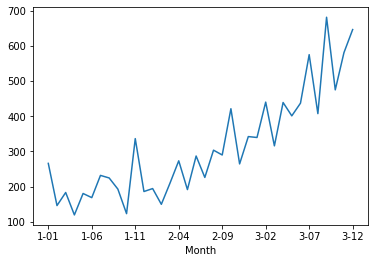

In [13]:
df.plot()

<AxesSubplot:xlabel='Month'>

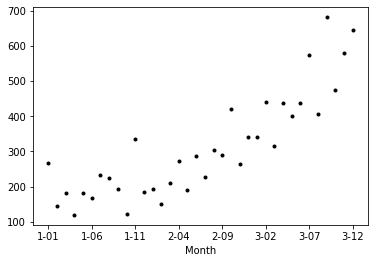

In [14]:
df.plot(style= '.k')

In [15]:
df.shape

(36,)

In [16]:
df.describe()

count     36.000000
mean     312.600000
std      148.937164
min      119.300000
25%      192.450000
50%      280.150000
75%      411.100000
max      682.000000
Name: Sales, dtype: float64